In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("new data/train_data_new.csv")
test_data = pd.read_csv("new data/test_data_new.csv")

y_train = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)

print(train_data.shape)
print(test_data.shape)

(1458, 252)
(1459, 251)


In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=10, random_state=42, shuffle=True)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from mlxtend.regressor import StackingCVRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

gbr = GradientBoostingRegressor(learning_rate=0.05, 
                                n_estimators=500,
                                max_depth=2,
                                min_samples_leaf=19,
                                min_samples_split=5,
                                max_features='log2', 
                                subsample=0.5,
                                loss='huber',
                                random_state=42)

rf = RandomForestRegressor(n_estimators=500,
                          max_depth=12,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

xgboost = XGBRegressor(learning_rate=0.05,
                       n_estimators=1000,
                       max_depth=9,
                       min_child_weight=3,
                       gamma=0.8,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       reg_alpha=0,
                       reg_lambda=1,
                       objective='reg:squarederror',
                       random_state=42)

lightgbm = LGBMRegressor(learning_rate=0.05, 
                         n_estimators=800,
                         max_depth=6,
                         num_leaves=30,
                         min_child_weight=3,
                         subsample=0.5,
                         colsample_bytree=0.5,
                         reg_alpha=10,
                         reg_lambda=24,
                         objective='regression',
                         random_state=42)

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

stack_gen = StackingCVRegressor(regressors=(gbr, rf, xgboost, lightgbm, ridge),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [5]:
models = [('gbr', gbr), ('rf', rf), ('xgb', xgboost), ('lgb', lightgbm), ('ridge', ridge)]
scores = {}

for name, model in models:
    score = cv_rmse(model)
    print("{}: {:.4f} ({:.4f})".format(name, score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())

gbr: 0.1947 (0.0210)
rf: 0.1906 (0.0195)
xgb: 0.1832 (0.0201)
lgb: 0.1861 (0.0203)
ridge: 0.2273 (0.0916)


In [6]:
models = [('gbr', gbr), ('rf', rf), ('xgb', xgboost), ('lgb', lightgbm), ('ridge', ridge), ('stack_model', stack_gen)]

for name, model in models:
    print("{} begin fit".format(name))
    if name == 'stack_model':
        stack_model_data = model.fit(np.array(X_train), np.array(y_train))
    elif name == 'xgb':
        xgb_model_data = model.fit(X_train, y_train)
    elif name == 'lgb':
        lgb_model_data = model.fit(X_train, y_train)
    elif name == 'ridge':
        ridge_model_data = model.fit(X_train, y_train)
    elif name == 'gbr':
        gbr_model_data = model.fit(X_train, y_train)
    else:
        rf_model_data = model.fit(X_train, y_train)
    print("{} finish fit".format(name))
    print("----")

gbr begin fit
gbr finish fit
----
rf begin fit
rf finish fit
----
xgb begin fit
xgb finish fit
----
lgb begin fit
lgb finish fit
----
ridge begin fit
ridge finish fit
----
stack_model begin fit
stack_model finish fit
----


In [7]:
def blended_predictions(X):
    return ((0.05 * ridge_model_data.predict(X)) + \
            (0.1 * gbr_model_data.predict(X)) + \
            (0.2 * xgb_model_data.predict(X)) + \
            (0.15 * lgb_model_data.predict(X)) + \
            (0.1 * rf_model_data.predict(X)) + \
            (0.4 * stack_model_data.predict(np.array(X))))

blended_score = rmse(y_train, blended_predictions(X_train))
scores['blended'] = (blended_score, 0)
print(blended_score)

0.10500885918332026


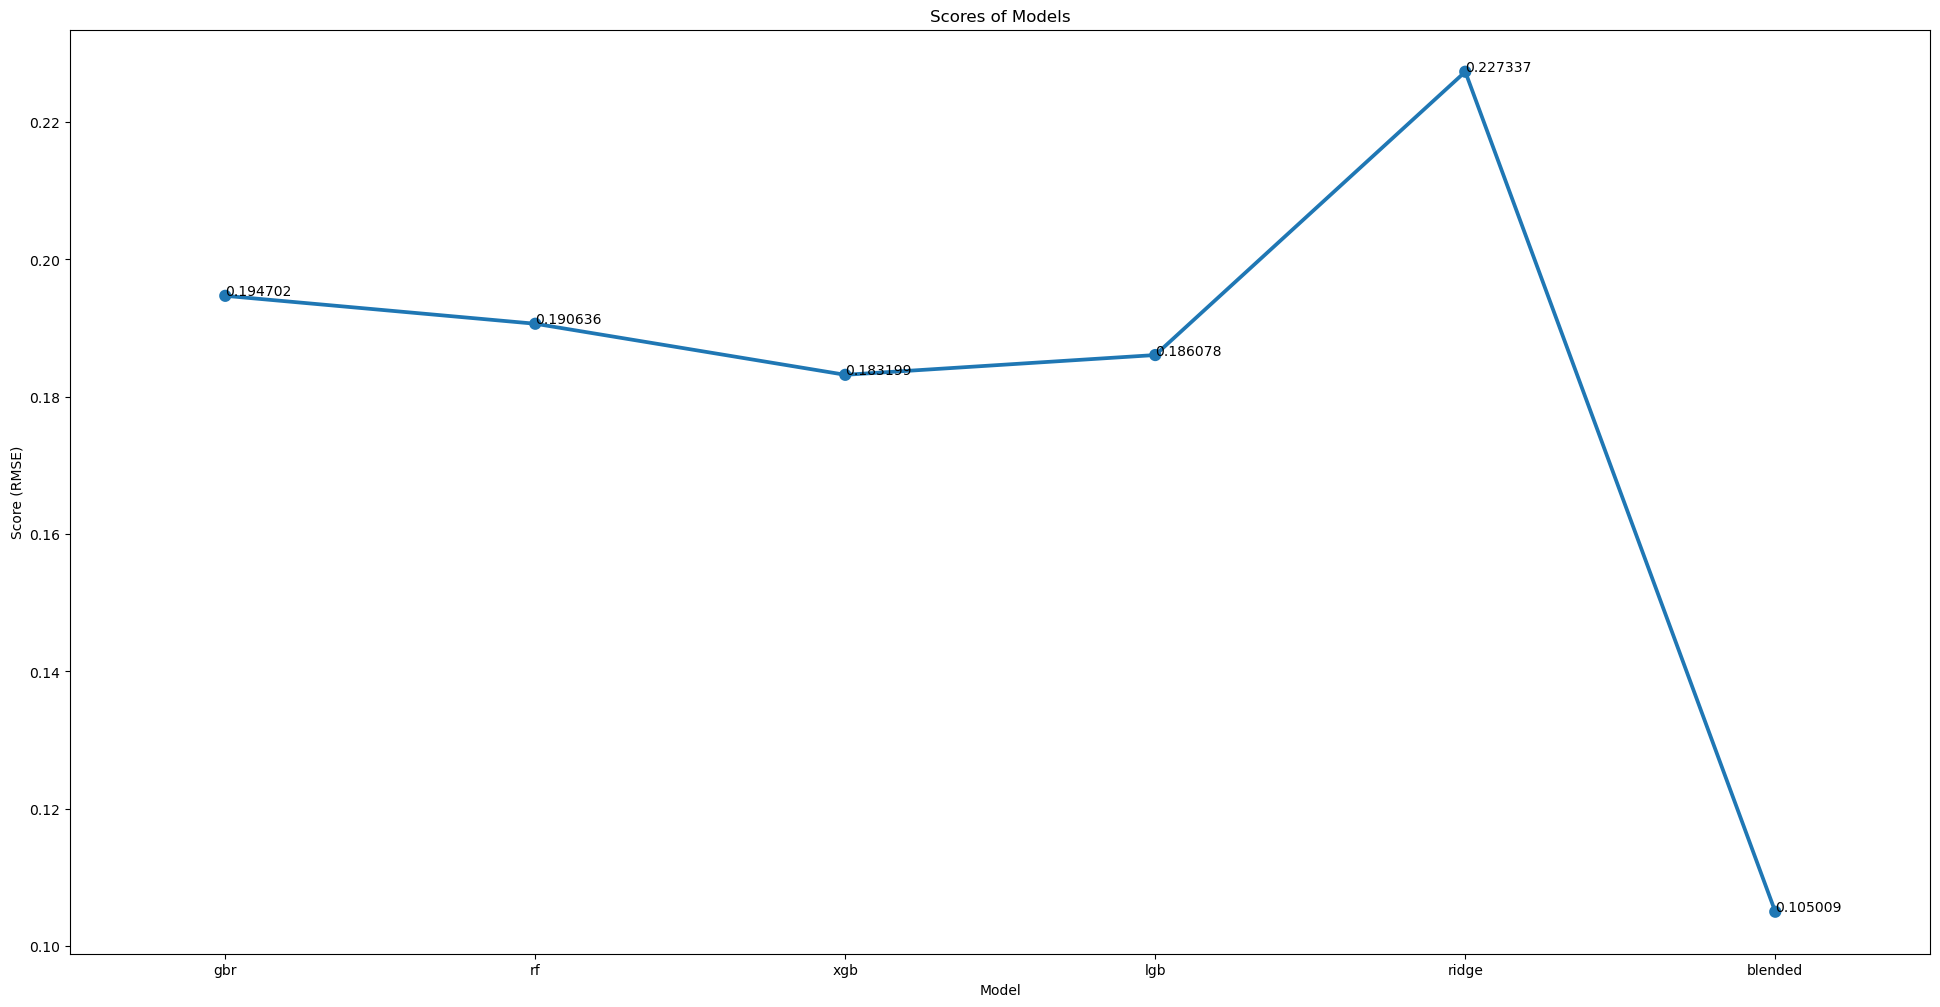

In [8]:
_, ax = plt.subplots(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0], '{:.6f}'.format(score[0]))

plt.ylabel('Score (RMSE)')
plt.xlabel('Model')
plt.title('Scores of Models')

plt.show()

In [9]:
y_test_pred = blended_predictions(test_data)
print(y_test_pred.shape)

(1459,)


In [11]:
submission = pd.read_csv("competition origin data/sample_submission.csv")

submission.iloc[:,1] = np.floor(np.expm1(y_test_pred))
submission.to_csv("submission.csv", index=False)